# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from scipy.sparse import csr_matrix
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Load dataset

In [2]:
default_dataset = load_dataset("sst", "default")

In [3]:
print("Default:",default_dataset)

Default: DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})


## Check dataset

### Default format

In [4]:
train_def = default_dataset["train"].to_pandas()
test_def = default_dataset["test"].to_pandas()
val_def = default_dataset["validation"].to_pandas()
print(train_def.head())
print(test_def.head())
print(val_def.head())

                                            sentence    label  \
0  The Rock is destined to be the 21st Century 's...  0.69444   
1  The gorgeously elaborate continuation of `` Th...  0.83333   
2  Singer\/composer Bryan Adams contributes a sle...  0.62500   
3  You 'd think by now America would have had eno...  0.50000   
4               Yet the act is still charming here .  0.72222   

                                              tokens  \
0  The|Rock|is|destined|to|be|the|21st|Century|'s...   
1  The|gorgeously|elaborate|continuation|of|``|Th...   
2  Singer\/composer|Bryan|Adams|contributes|a|sle...   
3  You|'d|think|by|now|America|would|have|had|eno...   
4               Yet|the|act|is|still|charming|here|.   

                                                tree  
0  70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|5...  
1  71|70|69|69|67|67|66|64|63|62|62|61|61|58|57|5...  
2  72|71|71|70|68|68|67|67|66|63|62|62|60|60|58|5...  
3  36|35|34|33|33|32|30|29|27|26|25|24|23|23|22|2...

## We will use the default config

In [5]:
X_train_def = train_def["sentence"]
y_train_def = train_def["label"]
X_test_def = test_def["sentence"]
y_test_def = test_def["label"]
X_val_def = val_def["sentence"]
y_val_def = val_def["label"]
print(X_train_def.head())
print(y_train_def.head())
print(X_test_def.head())
print(y_test_def.head())
print(X_val_def.head())
print(y_val_def.head())

0    The Rock is destined to be the 21st Century 's...
1    The gorgeously elaborate continuation of `` Th...
2    Singer\/composer Bryan Adams contributes a sle...
3    You 'd think by now America would have had eno...
4                 Yet the act is still charming here .
Name: sentence, dtype: object
0    0.69444
1    0.83333
2    0.62500
3    0.50000
4    0.72222
Name: label, dtype: float32
0                       Effective but too-tepid biopic
1    If you sometimes like to go to the movies to h...
2    Emerges as something rare , an issue movie tha...
3    The film provides some great insight into the ...
4    Offers that rare combination of entertainment ...
Name: sentence, dtype: object
0    0.51389
1    0.73611
2    0.86111
3    0.59722
4    0.83333
Name: label, dtype: float32
0    It 's a lovely film with lovely performances b...
1    No one goes unindicted here , which is probabl...
2    And if you 're not nearly moved to tears by a ...
3                     A warm , funny , 

# Preprocessing

### Map function

In [6]:
# Map the scores to sentiment classes
def map_sentiment(score):
    if score <= 0.2:
        return 0
    elif score <= 0.4:
        return 1
    elif score <= 0.6:
        return 2
    elif score <= 0.8:
        return 3
    else:
        return 4

In [7]:
# Map the scores to sentiment classes
y_train = y_train_def.apply(map_sentiment)
y_test = y_test_def.apply(map_sentiment)
y_val = y_val_def.apply(map_sentiment)
print(y_train.unique())
print(y_test.unique())
print(y_val.unique())

[3 4 2 1 0]
[2 3 4 1 0]
[3 2 4 0 1]


# Models

## Naive Bayes

### Feature extraction

In [8]:
X_train_def.shape

(8544,)

In [9]:
# vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
# X_train = vectorizer.fit_transform(X_train_def).astype(int)
# X_test = vectorizer.transform(X_test_def).astype(int)
# X_val = vectorizer.transform(X_val_def).astype(int)
# print(vectorizer.get_feature_names_out())
# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

### Implementation from scratch

In [10]:
import numpy as np

class NaiveBayes:
    def __init__(self, smoothing_factor=1):
        self.classes = None
        self.class_priors = None
        self.feature_log_prob_ = None  # Changed name to match scikit-learn's convention
        self.smoothing_factor = smoothing_factor
        self.vocab = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.vocab = self.get_vocab(X)
        self.class_priors = self.calculate_class_priors(y)
        self.feature_log_prob_ = self.calculate_feature_log_prob(X, y)  # Changed method name

    def get_vocab(self, X):
        # create a set from every document
        sets = X.apply(lambda x: set(x.split(" ")))
        
        # merge all sets
        vocab = set()
        for s in sets:
            vocab |= s
        
        # create a dictionary with the words and their indexes
        dic = {}
        for i in range(len(vocab)):
            dic[vocab.pop()] = i
        
        return dic
        
    def calculate_class_priors(self, y):
        class_priors = []
        for c in self.classes:
            class_priors.append(np.mean(y == c))
        return class_priors

    def calculate_feature_log_prob(self, X, y):
        def count_words(doc):
            words_count = np.zeros(len(self.vocab))
            for word in doc.split(" "):
                ind = self.vocab[word]
                words_count[ind] += 1
            return words_count
        
        words_count_per_class = np.array([np.zeros(len(self.vocab)) for _ in range(len(self.classes))])
        words_total_per_class = np.zeros(len(self.classes))
        for i in range(len(X)):
            words_count = count_words(X[i])
            words_count_per_class[y[i]] += words_count
            
            total_words = len(X[i].split(" "))
            words_total_per_class[y[i]] += total_words
        
        feature_log_prob_ = []
        for i in range(len(self.classes)):
            feature_log_prob_.append(np.log((words_count_per_class[i] + self.smoothing_factor) / (words_total_per_class[i] + len(self.vocab) * self.smoothing_factor)))

        return feature_log_prob_

    def predict(self, X):
        predictions = []

        for doc in X:
            words_count = np.zeros(len(self.vocab))
            for word in doc.split(" "):
                if word in self.vocab:
                    ind = self.vocab[word]
                    words_count[ind] += 1
            
            probs = []
            for i in range(len(self.classes)):
                prob = np.log(self.class_priors[i]) + np.sum(self.feature_log_prob_[i] * words_count)
                probs.append(prob)
            
            predictions.append(np.argmax(probs))

        return predictions

    def log_prior(self):
        return np.log(self.class_priors)

    def log_likelihood(self):
        return self.feature_log_prob_  # No need to modify this, as it already returns log probabilities
                

In [11]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train_def, y_train)
nb1 = naive_bayes

In [12]:
print(nb1.classes)

[0 1 2 3 4]


In [13]:
nb1_predictions = nb1.predict(X_test_def)
print(nb1_predictions[:10])

[2, 3, 3, 3, 4, 2, 2, 1, 3, 3]


In [14]:
preds = np.array(nb1_predictions)
print(np.unique(preds, return_counts=True))

(array([0, 1, 2, 3, 4]), array([  47,  911,  127, 1015,  110]))


### Implementation using scikit learn

In [15]:
vectorizer = CountVectorizer(analyzer='word')
X_train = vectorizer.fit_transform(X_train_def).astype(int)
X_test = vectorizer.transform(X_test_def).astype(int)
X_val = vectorizer.transform(X_val_def).astype(int)

In [16]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
nb2 = naive_bayes

In [17]:
print(nb2.class_log_prior_)
print(nb1.log_prior())
print(sorted(nb2.feature_log_prob_[0])[:10])
print(sorted(nb1.log_likelihood()[0])[:10])

[-2.0572184  -1.34862339 -1.66033704 -1.3028004  -1.89213865]
[-2.0572184  -1.34862339 -1.66033704 -1.3028004  -1.89213865]
[-10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095, -10.402837582827095]
[-10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662, -10.576763603453662]


In [18]:
preds2 = nb2.predict(X_test)

In [19]:
print(np.unique(preds, return_counts=True))
print(np.unique(preds2, return_counts=True))


(array([0, 1, 2, 3, 4]), array([  47,  911,  127, 1015,  110]))
(array([0, 1, 2, 3, 4]), array([ 62, 896, 152, 948, 152]))


Same logs so both models work the same

In [20]:
nb2_predictions = nb2.predict(X_test)
print(nb2_predictions[:10])
print(nb1_predictions[:10])

[1 3 3 3 3 2 2 2 3 3]
[2, 3, 3, 3, 4, 2, 2, 1, 3, 3]


In [21]:
nb1_accuracy = np.mean(nb1_predictions == y_test)
nb2_accuracy = np.mean(nb2_predictions == y_test)
print("Naive Bayes (from scratch) accuracy:", nb1_accuracy)
print("Naive Bayes (scikit-learn) accuracy:", nb2_accuracy)

Naive Bayes (from scratch) accuracy: 0.39683257918552034
Naive Bayes (scikit-learn) accuracy: 0.4090497737556561


## Logistic Regression

### Implement Logistic Regression from scratch

In [22]:
class LogisticRegressionClassifier:
    def __init__(self, learning_rate=0.01, num_iterations=100):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bigrams = None
        self.bias = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def get_bigrams(self, X):
        bigrams = {}
        for doc in X:
            doc = doc.split(" ")
            for i in range(len(doc) - 1):
                bi = doc[i] + " " + doc[i+1]
                if bi not in bigrams:
                    bigrams[bi] = len(bigrams) 
        return bigrams
    
    def initialize_parameters(self, num_features, num_classes):
        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros((1, num_classes))
    
    def vectorize(self, X):
        X = X.apply(lambda x: x.split(" "))
        X_vectorized = np.zeros((len(X), len(self.bigrams)), dtype=bool)
        for i in range(len(X)):
            for j in range(len(X[i])- 1):
                bigram = X[i][j] + " " + X[i][j+1]
                if bigram in self.bigrams:
                    X_vectorized[i][self.bigrams[bigram]] = True
        return X_vectorized
    
    def fit(self, X, y, x_val, y_val, lr=0.01, num_iter=1000):
        self.learning_rate = lr
        self.num_iterations = num_iter
        self.bigrams = self.get_bigrams(X)
        X = self.vectorize(X)
        x_val = self.vectorize(x_val)
        return self.train(X, y, x_val, y_val)
    
    def multiclass_cross_entropy_loss(self, y, y_pred):
        num_samples = len(y)
        loss = -1/num_samples * np.sum(y * np.log(y_pred))
        return loss
    
    def train(self, X, y, x_val, y_val):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))
        if self.weights is None:
            self.initialize_parameters(num_features, num_classes)

        y_encoded = np.zeros((num_samples, num_classes))
        y_encoded[np.arange(num_samples), y] = 1
        
        y_val_encoded = np.zeros((len(y_val), num_classes))
        y_val_encoded[np.arange(len(y_val)), y_val] = 1
        
        history = {
            "train_loss": [],
            "train_accuracy": [],
            "val_loss": [],
            "val_accuracy": []
        }
        for i in range(self.num_iterations):
            linear_model = X.dot(self.weights) + self.bias
            y_pred = self.softmax(linear_model)

            dw = (1 / num_samples) * X.T.dot((y_pred - y_encoded))
            db = (1 / num_samples) * np.sum(y_pred - y_encoded, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if i % 20 == 0:
                train_loss = self.multiclass_cross_entropy_loss(y_encoded, y_pred)
                train_accuracy = np.mean(np.argmax(y_pred, axis=1) == y)
                history["train_loss"].append(train_loss)
                history["train_accuracy"].append(train_accuracy)
                
                val_pred = self.predict_proba(x_val)
                val_loss = self.multiclass_cross_entropy_loss(y_val_encoded, val_pred)
                val_accuracy = np.mean(np.argmax(val_pred, axis=1) == y_val)
                history["val_loss"].append(val_loss)
                history["val_accuracy"].append(val_accuracy)
                
                print(f"iter {i}: train_loss {train_loss:.4f} train_accuracy {train_accuracy:.4f} val_loss {val_loss:.4f} val_accuracy {val_accuracy:.4f}")
                if i > 20 and history["val_loss"][-2] - history["val_loss"][-1] < 0.0002:
                    break
        return history
    
    def softmax(self, z):
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)
    
    def predict_proba(self, X):
        linear_model = X.dot(self.weights) + self.bias
        y_pred = self.softmax(linear_model)
        return y_pred

    def predict(self, X):
        X = self.vectorize(X)
        y_pred_proba = self.predict_proba(X)
        y_pred_class = np.argmax(y_pred_proba, axis=1)
        return y_pred_class

In [24]:
lr_classifier = LogisticRegressionClassifier()
history = lr_classifier.fit(X_train_def, y_train, X_val_def, y_val, lr=0.5, num_iter=100)
lr1 = lr_classifier

iter 0: train_loss 1.6094 train_accuracy 0.1278 val_loss 1.6013 val_accuracy 0.2534
iter 20: train_loss 1.5457 train_accuracy 0.3349 val_loss 1.5657 val_accuracy 0.2743
iter 40: train_loss 1.5238 train_accuracy 0.4235 val_loss 1.5598 val_accuracy 0.3097
iter 60: train_loss 1.5036 train_accuracy 0.4538 val_loss 1.5549 val_accuracy 0.3243
iter 80: train_loss 1.4843 train_accuracy 0.4611 val_loss 1.5507 val_accuracy 0.3279


In [25]:
lr1_predictions = lr1.predict(X_test_def)
accuracy = np.mean(lr1_predictions == y_test)
accuracy

0.32941176470588235

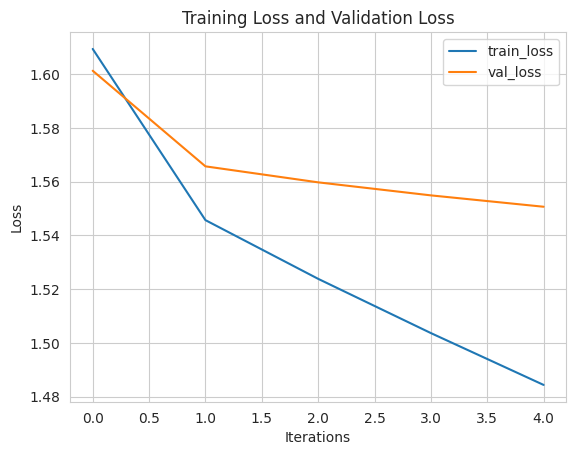

In [26]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss and Validation Loss")
plt.legend()
plt.show()

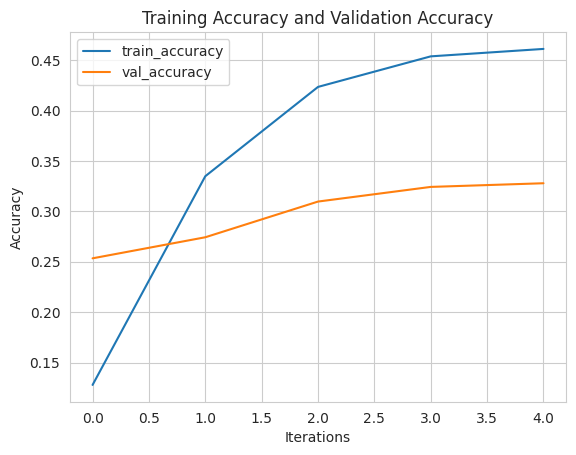

In [27]:
# Plot the training accuracy and validation accuracy
plt.plot(history["train_accuracy"], label="train_accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.legend()
plt.show()

## Implement Logistic Regression from scikit learn

In [28]:
lr_classifier = LogisticRegression(max_iter=10000, penalty=None)
lr2 = lr_classifier.fit(X_train, y_train)

In [29]:
lr_classifier = SGDClassifier(max_iter=10000, loss="log_loss", penalty=None)
lr3 = lr_classifier.fit(X_train, y_train)

In [30]:
lr2_predictions = lr2.predict(X_test)
lr3_predictions = lr3.predict(X_test)

lr2_accuracy = np.mean(lr2_predictions == y_test)
lr3_accuracy = np.mean(lr3_predictions == y_test)

print("Logistic Regression (scikit-learn) accuracy:", lr2_accuracy)
print("Logistic Regression (scikit-learn with scaling) accuracy:", lr3_accuracy)

Logistic Regression (scikit-learn) accuracy: 0.3592760180995475
Logistic Regression (scikit-learn with scaling) accuracy: 0.3760180995475113


# Confusion Matrix &Evaluation Metrics

### Confusion Matrix using scikit learn

In [31]:
def generate_confusion_matrix1(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = np.unique(np.concatenate((y_true, y_pred)))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return cm_df

### Confusion Matrix from scratch

In [32]:
def generate_confusion_matrix2(y_true, y_pred):
    labels = np.unique(np.concatenate((y_true, y_pred)))
    num_labels = len(labels)
    cm = np.zeros((num_labels, num_labels), dtype=int)
    
    for i in range(len(y_true)):
        true_label = np.where(labels == y_true[i])[0][0]
        pred_label = np.where(labels == y_pred[i])[0][0]
        cm[true_label][pred_label] += 1
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return cm_df

### Metrics from scratch

In [33]:
def compute_metrics(confusion_matrix):
    # Get the unique labels
    labels = confusion_matrix.index.tolist()

    # Initialize lists to store precision, recall, and F1 score per class
    precision_per_class = []
    recall_per_class = []
    f1_score_per_class = []

    # Compute precision, recall, and F1 score per class
    for label in labels:
        true_positives = confusion_matrix.loc[label, label]
        false_positives = confusion_matrix.loc[:, label].sum() - true_positives
        false_negatives = confusion_matrix.loc[label, :].sum() - true_positives

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)

        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_score_per_class.append(f1)

    # Compute macro-averaged precision, recall, and F1 score
    macro_precision = sum(precision_per_class) / len(precision_per_class)
    macro_recall = sum(recall_per_class) / len(recall_per_class)
    macro_f1_score = sum(f1_score_per_class) / len(f1_score_per_class)

    return {
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_score_per_class': f1_score_per_class,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1_score': macro_f1_score
    }

In [34]:
model = nb2 # Change to nb2, lr1, or lr2 to generate confusion matrix for other models
y_pred = model.predict(X_test)

In [35]:
models = [nb1, nb2, lr1, lr2, lr3]
model_names = ["Naive Bayes (from scratch)", "Naive Bayes (scikit-learn)", "Logistic Regression (from scratch)", "Logistic Regression (scikit-learn)", "Logistic Regression (scikit-learn with scaling)"]


print(f"Model {model_names[0]}: {np.mean(nb1_predictions == y_test)}")
print(f"Model {model_names[1]}: {np.mean(nb2_predictions == y_test)}")
print(f"Model {model_names[2]}: {np.mean(lr1_predictions == y_test)}")
print(f"Model {model_names[0]}: {np.mean(lr2_predictions == y_test)}")
print(f"Model {model_names[0]}: {np.mean(lr3_predictions == y_test)}")

Model Naive Bayes (from scratch): 0.39683257918552034
Model Naive Bayes (scikit-learn): 0.4090497737556561
Model Logistic Regression (from scratch): 0.32941176470588235
Model Naive Bayes (from scratch): 0.3592760180995475
Model Naive Bayes (from scratch): 0.3760180995475113


Confusion matrix using scikit learn

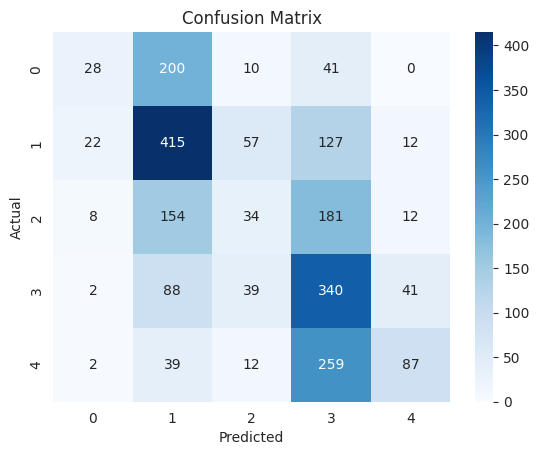

In [36]:
cm1 = generate_confusion_matrix1(y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm1, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confusion matrix from scratch

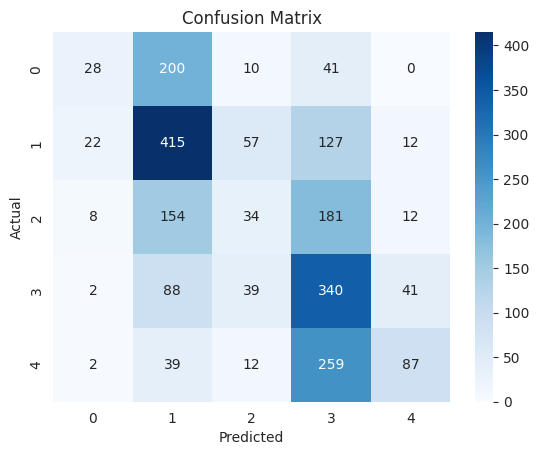

In [37]:
cm2 = generate_confusion_matrix2(y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
Metrics = compute_metrics(cm2)
precision_scratch, recall_scratch, f1_scratch = Metrics['precision_per_class'], Metrics['recall_per_class'], Metrics['f1_score_per_class']
# Calculate precision, recall, and F1 score using sklearn functions
precision_sklearn = precision_score(y_test, y_pred, average=None)
recall_sklearn = recall_score(y_test, y_pred, average=None)
f1_sklearn = f1_score(y_test, y_pred, average=None)

# Compare the metrics
print("Precision (from scratch):", precision_scratch)
print("Precision (sklearn):", precision_sklearn)
print("---------------------------------")
print("Recall (from scratch):", recall_scratch)
print("Recall (sklearn):", recall_sklearn)
print("---------------------------------")
print("F1 Score (from scratch):", f1_scratch)
print("F1 Score (sklearn):", f1_sklearn)


Precision (from scratch): [0.45161290322580644, 0.46316964285714285, 0.2236842105263158, 0.35864978902953587, 0.5723684210526315]
Precision (sklearn): [0.4516129  0.46316964 0.22368421 0.35864979 0.57236842]
---------------------------------
Recall (from scratch): [0.1003584229390681, 0.655608214849921, 0.08740359897172237, 0.6666666666666666, 0.21804511278195488]
Recall (sklearn): [0.10035842 0.65560821 0.0874036  0.66666667 0.21804511]
---------------------------------
F1 Score (from scratch): [0.16422287390029328, 0.5428384565075213, 0.1256931608133087, 0.46639231824417016, 0.3157894736842105]
F1 Score (sklearn): [0.16422287 0.54283846 0.12569316 0.46639232 0.31578947]
